In [1]:
import os
import torch
import torch.nn as nn
from PIL import Image, ImageFont
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.transforms import (
    Compose,
    ToTensor,
    RandomResizedCrop,
    RandomRotation,
    Resize,
)
from IPython.display import display
import gradio as gr

from utils.transform_image import draw_text_with_new_lines, char_size, my_transform
from utils.initialize_font_data import (
    fox_text,
    fox_text_four_lines,
    exclusive_attributes,
)
from utils.clip_vae import VAELoss

try:
    from torchvision.transforms import InterpolationMode

    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

device = "cuda:0" if torch.cuda.is_available() else "cpu"

exclusive_attributes:  ['capitals', 'cursive', 'display', 'italic', 'monospace', 'serif']


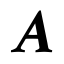

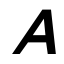

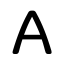

In [2]:
font_dir_path = "../gwfonts-200/"
font_paths = [
    os.path.join(font_dir_path, font_name) for font_name in os.listdir(font_dir_path)
]
text = "A"
count = 0
for font_path in font_paths:
    font = ImageFont.truetype(font_path, size=64)
    image = draw_text_with_new_lines(text, font, 64, 64)
    display(image)
    count += 1
    if count > 2:
        break

In [3]:
def transform(n_px=64, augmentation=False, lower_bound_of_scale=0.15) -> Compose:
    if augmentation:
        return Compose(
            [
                RandomRotation(180, fill=255),
                RandomResizedCrop(
                    n_px,
                    scale=(lower_bound_of_scale, 1.0),
                    ratio=(1.0, 1.0),
                    interpolation=BICUBIC,
                ),
                # to black and white
                lambda x: x.convert("L"),
                ToTensor(),
            ]
        )

    return Compose(
        [
            Resize(n_px, interpolation=BICUBIC),
            # to black and white
            lambda x: x.convert("L"),
            ToTensor(),
        ]
    )


vae_preprocess = transform()

In [4]:
class SimpleVAEDataset(Dataset):
    def __init__(
        self,
        font_dir_path,
        target_texts=None,
        char_size=64,
        img_size=64,
        augmentation=False,
        lower_bound_of_scale=0.15,
        aug_sample_num=1,
        n_px=64,
    ):
        self.target_texts = target_texts
        self.font_paths = [
            os.path.join(font_dir_path, font_name)
            for font_name in os.listdir(font_dir_path)
        ]
        self.vae_preprocess = transform(
            n_px=n_px,
            augmentation=augmentation,
            lower_bound_of_scale=lower_bound_of_scale,
        )

        # generate image tensors
        self.image_tensors = []
        for font_path in tqdm(self.font_paths):
            font = ImageFont.truetype(font_path, size=char_size)
            for text in self.target_texts:
                image = draw_text_with_new_lines(
                    text, font, img_size, img_size)
                for _ in range(aug_sample_num):
                    image_tensor = self.vae_preprocess(image)
                    self.image_tensors.append(image_tensor)

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, idx):
        return self.image_tensors[idx]

In [5]:
dataset = SimpleVAEDataset(
    font_dir_path,
    target_texts=[fox_text_four_lines],
    char_size=64,
    img_size=300,
    augmentation=True,
    aug_sample_num=5,
)
# dataset = SimpleVAEDataset(font_dir_path, target_texts=['A'], char_size=64, vae_preprocess=vae_preprocess)
print("len of dataset", len(dataset))
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

100%|██████████| 200/200 [00:00<00:00, 302.55it/s]

len of dataset 1000


torch.Size([32, 1, 64, 64])


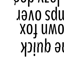

In [6]:
it = iter(data_loader)
images = next(it)
print(images.shape)
display(to_pil_image(images[0]))

In [11]:
class ResDown(nn.Module):
    """
    Residual down sampling block for the encoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, mode_224=False):
        super(ResDown, self).__init__()
        self.mode_224 = mode_224
        self.conv1 = nn.Conv2d(
            channel_in, channel_out // 2, kernel_size, 2, kernel_size // 2
        )
        self.bn1 = nn.BatchNorm2d(channel_out // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(
            channel_out // 2, channel_out, kernel_size, 1, kernel_size // 2
        )
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(
            channel_in, channel_out, kernel_size, 2, kernel_size // 2
        )

        self.act_fnc = nn.ELU()
        if self.mode_224:
            self.down_nn = nn.Upsample(scale_factor=128 / 112, mode="nearest")

    def forward(self, x):
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        x = self.act_fnc(self.bn2(x + skip))
        if self.mode_224:
            x = self.down_nn(x)
        return x


class ResUp(nn.Module):
    """
    Residual up sampling block for the decoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, scale_factor=2, dropout=False, dropout_rate=0.5):
        super(ResUp, self).__init__()
        self.dropout = dropout
        if self.dropout:
            self.dropout1 = nn.Dropout(dropout_rate)
            self.dropout2 = nn.Dropout(dropout_rate)

        self.conv1 = nn.Conv2d(
            channel_in, channel_in // 2, kernel_size, 1, kernel_size // 2
        )
        self.bn1 = nn.BatchNorm2d(channel_in // 2, eps=1e-4)

        self.conv2 = nn.Conv2d(
            channel_in // 2, channel_out, kernel_size, 1, kernel_size // 2
        )
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(
            channel_in, channel_out, kernel_size, 1, kernel_size // 2
        )

        self.up_nn = nn.Upsample(scale_factor=scale_factor, mode="nearest")

        # self.act_fnc = nn.ELU()
        self.act_fnc = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.up_nn(x)
        skip = self.conv3(x)
        x = self.conv1(x)
        if self.dropout:
            x = self.dropout1(x)
        x = self.act_fnc(self.bn1(x))
        x = self.conv2(x)
        if self.dropout:
            x = self.dropout2(x)

        return self.act_fnc(self.bn2(x + skip))


class ResBlock(nn.Module):
    """
    Residual block
    """

    def __init__(self, channel_in, channel_out, kernel_size=3):
        super(ResBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            channel_in, channel_in // 2, kernel_size, 1, kernel_size // 2
        )
        self.bn1 = nn.BatchNorm2d(channel_in // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(
            channel_in // 2, channel_out, kernel_size, 1, kernel_size // 2
        )
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        if not channel_in == channel_out:
            self.conv3 = nn.Conv2d(
                channel_in, channel_out, kernel_size, 1, kernel_size // 2
            )
        else:
            self.conv3 = nn.Identity()

        # self.act_fnc = nn.ELU()
        self.act_fnc = nn.LeakyReLU(0.2)

    def forward(self, x):
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)

        return self.act_fnc(self.bn2(x + skip))


class Encoder(nn.Module):
    """
    Encoder block
    """

    def __init__(
        self,
        channels,
        ch=64,
        blocks=(1, 2, 4, 8),
        latent_channels=512,
        eval=False,
        mode_224=False,
    ):
        super(Encoder, self).__init__()
        self.latent_channels = latent_channels
        self.mode_224 = mode_224
        self.eval = eval
        if self.mode_224:
            self.conv_in = nn.Conv2d(channels, blocks[0] * ch // 4, 3, 1, 1)
            self.res_down_block0_0 = ResDown(
                blocks[0] * ch // 4, blocks[0] * ch // 2, mode_224=True
            )
            self.res_down_block0_1 = ResDown(blocks[0] * ch // 2, blocks[0] * ch)
        else:
            self.conv_in = nn.Conv2d(channels, blocks[0] * ch, 3, 1, 1)

        widths_in = list(blocks)
        widths_out = list(blocks[1:]) + [blocks[-1]]

        layer_blocks = []

        for w_in, w_out in zip(widths_in, widths_out):
            layer_blocks.append(ResDown(w_in * ch, w_out * ch))

        layer_blocks.append(ResBlock(blocks[-1] * ch, blocks[-1] * ch))
        layer_blocks.append(ResBlock(blocks[-1] * ch, blocks[-1] * ch))

        self.res_blocks = nn.Sequential(*layer_blocks)

        # self.conv_mu = nn.Conv2d(blocks[-1] * ch, latent_channels, 1, 1)
        # self.conv_log_var = nn.Conv2d(blocks[-1] * ch, latent_channels, 1, 1)
        self.x_width = 64
        for _ in range(len(blocks)):
            self.x_width = self.x_width // 2
        self.conv_mu = nn.Linear(
            blocks[-1] * ch * self.x_width * self.x_width,
            latent_channels * self.x_width * self.x_width,
        )
        self.conv_log_var = nn.Linear(
            blocks[-1] * ch * self.x_width * self.x_width,
            latent_channels * self.x_width * self.x_width,
        )
        self.act_fnc = nn.ELU()
        self.act_fnc = nn.LeakyReLU(0.2)

    def sample(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        if self.mode_224:
            x = self.res_down_block0_0(x)
            x = self.res_down_block0_1(x)
        x = self.res_blocks(x)

        x = x.view(x.shape[0], -1)

        mu = self.conv_mu(x)
        log_var = self.conv_log_var(x)
        mu = mu.view(mu.shape[0], self.latent_channels, self.x_width, self.x_width)
        log_var = log_var.view(
            log_var.shape[0], self.latent_channels, self.x_width, self.x_width
        )

        if self.eval:
            x = mu
        else:
            x = self.sample(mu, log_var)

        return x, mu, log_var


class Decoder(nn.Module):
    """
    Decoder block
    Built to be a mirror of the encoder block
    """

    def __init__(
        self, channels, ch=64, blocks=(1, 2, 4, 8), latent_channels=512, mode_224=False, dropout=False, dropout_rate=0.5
    ):
        super(Decoder, self).__init__()
        self.mode_224 = mode_224
        self.conv_in = nn.Conv2d(latent_channels, ch * blocks[-1], 1, 1)

        widths_out = list(blocks)[::-1]
        widths_in = (list(blocks[1:]) + [blocks[-1]])[::-1]

        layer_blocks = [
            ResBlock(blocks[-1] * ch, blocks[-1] * ch),
            ResBlock(blocks[-1] * ch, blocks[-1] * ch),
        ]

        for w_in, w_out in zip(widths_in, widths_out):
            layer_blocks.append(ResUp(w_in * ch, w_out * ch, dropout=dropout, dropout_rate=dropout_rate))

        self.res_blocks = nn.Sequential(*layer_blocks)

        if self.mode_224:
            self.res_up_block5 = ResUp(
                blocks[0] * ch, blocks[0] * ch // 2, scale_factor=112 / 64, dropout=dropout, dropout_rate=dropout_rate
            )
            self.res_up_block6 = ResUp(
                blocks[0] * ch // 2,
                blocks[0] * ch // 4,
                dropout=dropout,
                dropout_rate=dropout_rate,
            )
            self.conv_out = nn.Conv2d(blocks[0] * ch // 4, channels, 3, 1, 1)
        else:
            self.conv_out = nn.Conv2d(blocks[0] * ch, channels, 3, 1, 1)
        # self.act_fnc = nn.ELU()
        self.act_fnc = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        x = self.res_blocks(x)
        # mu = torch.tanh(self.conv_out(x))
        if self.mode_224:
            x = self.res_up_block5(x)  # 112
            x = self.res_up_block6(x)  # 224
        mu = self.sigmoid(self.conv_out(x))
        return mu


class VAE(nn.Module):
    """
    VAE network, uses the above encoder and decoder blocks
    """

    def __init__(
        self,
        channel_in=3,
        ch=64,
        blocks=(1, 2, 4, 8),
        latent_channels=512,
        mode_224=False,
        dropout=False,
        dropout_rate=0.5,
    ):
        super(VAE, self).__init__()
        """Res VAE Network
        channel_in  = number of channels of the image 
        z = the number of channels of the latent representation
        (for a 64x64 image this is the size of the latent vector)
        """
        self.mode_224 = mode_224
        self.encoder = Encoder(
            channel_in,
            ch=ch,
            blocks=blocks,
            latent_channels=latent_channels,
            mode_224=self.mode_224,
        )
        self.decoder = Decoder(
            channel_in,
            ch=ch,
            blocks=blocks,
            latent_channels=latent_channels,
            mode_224=self.mode_224,
            dropout=dropout,
            dropout_rate=dropout_rate,
        )

    def forward(self, x):
        encoding, mu, log_var = self.encoder(x)
        recon_img = self.decoder(encoding)
        return recon_img, mu, log_var

In [8]:
# dataset = SimpleVAEDataset(font_dir_path, target_texts=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O'])
dataset = SimpleVAEDataset(
    font_dir_path,
    target_texts=[
        fox_text_four_lines,
    ],
    char_size=100,
    img_size=500,
    augmentation=True,
    lower_bound_of_scale=0.35,
    aug_sample_num=70,
    n_px=64,
)
# dataset = SimpleVAEDataset(
#     font_dir_path,
#     target_texts=[
#         'A',
#         # 'B',
#         # 'C',
#         # 'D',
#         # 'E',
#         # 'F',
#         # 'G',
#         # 'H',
#     ],
#     char_size=64,
#     img_size=64,
#     augmentation=True,
#     lower_bound_of_scale=0.35,
#     aug_sample_num=100,
#     n_px=64
# )

100%|██████████| 200/200 [00:13<00:00, 14.68it/s]


In [34]:
batch_size = 64
ch = 64
latent_channels = 32
mode_224 = False
dropout = False
dropout_rate = 0.2
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# vae = VAE(channel_in=1, latent_channels=512, ch=64, mode_224=mode_224).to(device)
vae = VAE(
    channel_in=1,
    latent_channels=latent_channels,
    ch=ch,
    mode_224=mode_224,
    blocks=(
        1,
        2,
        4,
        8,
    ),
    dropout=dropout,
    dropout_rate=dropout_rate,
).to(device)
vae_loss = VAELoss(beta=0.001, rmse=False).to(device)

vae_checkpoint_path = None
# vae_checkpoint_path = "vae_model_checkpoints/resblock_vae_1_beta_0.01_fox_text_aug.pt"
vae_checkpoint_path = "vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt"
if vae_checkpoint_path is not None:
    vae.load_state_dict(torch.load(vae_checkpoint_path))

torch.Size([2, 1, 64, 64])
torch.Size([2, 32, 4, 4]) torch.Size([2, 32, 4, 4])
torch.Size([2, 1, 64, 64])


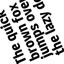

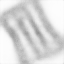

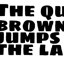

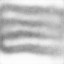

In [41]:
tmp_data_loader = DataLoader(dataset, batch_size=2, shuffle=True)
it = iter(tmp_data_loader)
sampled_images = next(it)
sampled_images = sampled_images.to(device)
print(sampled_images.shape)
recon_x, mean, var = vae(sampled_images)
# print(mean[0][0], var[0][0])
print(mean.shape, var.shape)
print(recon_x.shape)
display(to_pil_image(sampled_images[0]), to_pil_image(recon_x[0]))
display(to_pil_image(sampled_images[1]), to_pil_image(recon_x[1]))
sampled_images = sampled_images.cpu()
torch.cuda.empty_cache()

In [28]:
sampled_images = sampled_images.to(device)
x, mu, logvar = vae.encoder(sampled_images)
print(x.shape)

torch.Size([2, 32, 4, 4])


In [29]:
epoch = 10000
lr = 1e-5
vae_optimizer = optim.Adam(
    vae.parameters(),
    lr=lr,
    betas=(0.9, 0.98),
    eps=1e-6,
    weight_decay=0.2,
)
vae_schedular = optim.lr_scheduler.LinearLR(
    vae_optimizer,
    start_factor=1,
    end_factor=0.1,
    total_iters=epoch * len(data_loader),
)

  0%|          | 0/10000 [00:00<?, ?it/s]

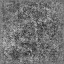

  0%|          | 1/10000 [00:00<1:05:57,  2.53it/s]

epoch: 0, loss: 1.5280543565750122
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  0%|          | 30/10000 [00:07<43:24,  3.83it/s] 

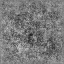

  0%|          | 31/10000 [00:08<50:59,  3.26it/s]

epoch: 30, loss: 1.453077495098114
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  1%|          | 60/10000 [00:15<42:49,  3.87it/s]

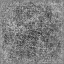

  1%|          | 61/10000 [00:16<50:01,  3.31it/s]

epoch: 60, loss: 1.3890092372894287
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  1%|          | 90/10000 [00:23<42:40,  3.87it/s]

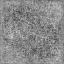

  1%|          | 91/10000 [00:24<50:11,  3.29it/s]

epoch: 90, loss: 1.3300828337669373
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  1%|          | 120/10000 [00:31<42:32,  3.87it/s]

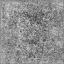

  1%|          | 121/10000 [00:32<49:38,  3.32it/s]

epoch: 120, loss: 1.2711597084999084
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  2%|▏         | 150/10000 [00:39<42:25,  3.87it/s]

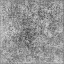

  2%|▏         | 151/10000 [00:39<49:55,  3.29it/s]

epoch: 150, loss: 1.2199758291244507
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  2%|▏         | 180/10000 [00:47<42:17,  3.87it/s]

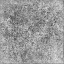

  2%|▏         | 181/10000 [00:47<49:20,  3.32it/s]

epoch: 180, loss: 1.1720735430717468
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  2%|▏         | 210/10000 [00:55<42:09,  3.87it/s]

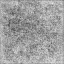

  2%|▏         | 211/10000 [00:55<49:34,  3.29it/s]

epoch: 210, loss: 1.1351224780082703
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  2%|▏         | 240/10000 [01:03<42:01,  3.87it/s]

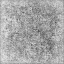

  2%|▏         | 241/10000 [01:03<49:19,  3.30it/s]

epoch: 240, loss: 1.0877450108528137
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  3%|▎         | 270/10000 [01:11<42:19,  3.83it/s]

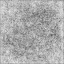

  3%|▎         | 271/10000 [01:11<49:23,  3.28it/s]

epoch: 270, loss: 1.059426486492157
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  3%|▎         | 300/10000 [01:19<41:57,  3.85it/s]

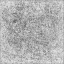

  3%|▎         | 301/10000 [01:19<49:31,  3.26it/s]

epoch: 300, loss: 1.0349206328392029
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  3%|▎         | 330/10000 [01:27<41:48,  3.85it/s]

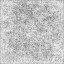

  3%|▎         | 331/10000 [01:27<48:55,  3.29it/s]

epoch: 330, loss: 1.0259482860565186
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  4%|▎         | 360/10000 [01:35<41:56,  3.83it/s]

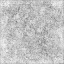

  4%|▎         | 361/10000 [01:35<49:47,  3.23it/s]

epoch: 360, loss: 0.9717504382133484
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  4%|▍         | 390/10000 [01:43<41:33,  3.85it/s]

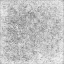

  4%|▍         | 391/10000 [01:43<48:25,  3.31it/s]

epoch: 390, loss: 0.9703106582164764
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  4%|▍         | 420/10000 [01:50<41:25,  3.85it/s]

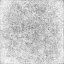

  4%|▍         | 421/10000 [01:51<48:37,  3.28it/s]

epoch: 420, loss: 0.9622707962989807
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  4%|▍         | 450/10000 [01:58<41:18,  3.85it/s]

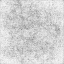

  5%|▍         | 451/10000 [01:59<41:43,  3.81it/s]

epoch: 450, loss: 0.9852434396743774


  5%|▍         | 480/10000 [02:06<41:25,  3.83it/s]

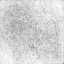

  5%|▍         | 481/10000 [02:07<48:13,  3.29it/s]

epoch: 480, loss: 0.9461216628551483
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  5%|▌         | 510/10000 [02:14<41:02,  3.85it/s]

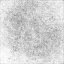

  5%|▌         | 511/10000 [02:15<48:14,  3.28it/s]

epoch: 510, loss: 0.9409318566322327
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  5%|▌         | 540/10000 [02:22<41:09,  3.83it/s]

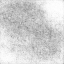

  5%|▌         | 541/10000 [02:23<48:04,  3.28it/s]

epoch: 540, loss: 0.9048353135585785
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  6%|▌         | 570/10000 [02:30<40:47,  3.85it/s]

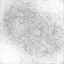

  6%|▌         | 571/10000 [02:30<48:00,  3.27it/s]

epoch: 570, loss: 0.9040574431419373
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  6%|▌         | 600/10000 [02:38<40:53,  3.83it/s]

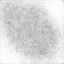

  6%|▌         | 601/10000 [02:38<41:17,  3.79it/s]

epoch: 600, loss: 0.9158793091773987


  6%|▋         | 630/10000 [02:46<40:31,  3.85it/s]

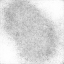

  6%|▋         | 631/10000 [02:46<40:55,  3.82it/s]

epoch: 630, loss: 0.9175522029399872


  7%|▋         | 660/10000 [02:54<40:38,  3.83it/s]

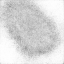

  7%|▋         | 661/10000 [02:54<47:22,  3.29it/s]

epoch: 660, loss: 0.8793725073337555
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  7%|▋         | 690/10000 [03:02<40:15,  3.85it/s]

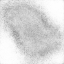

  7%|▋         | 691/10000 [03:02<47:18,  3.28it/s]

epoch: 690, loss: 0.8766222596168518
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  7%|▋         | 720/10000 [03:10<40:22,  3.83it/s]

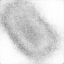

  7%|▋         | 721/10000 [03:10<40:46,  3.79it/s]

epoch: 720, loss: 0.8802525997161865


  8%|▊         | 750/10000 [03:17<39:59,  3.85it/s]

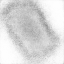

  8%|▊         | 751/10000 [03:18<40:22,  3.82it/s]

epoch: 750, loss: 0.8976984620094299


  8%|▊         | 780/10000 [03:25<39:52,  3.85it/s]

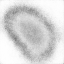

  8%|▊         | 781/10000 [03:26<46:33,  3.30it/s]

epoch: 780, loss: 0.8712468445301056
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  8%|▊         | 810/10000 [03:33<39:45,  3.85it/s]

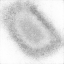

  8%|▊         | 811/10000 [03:34<46:36,  3.29it/s]

epoch: 810, loss: 0.8647560477256775
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  8%|▊         | 840/10000 [03:41<39:36,  3.85it/s]

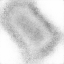

  8%|▊         | 841/10000 [03:41<39:59,  3.82it/s]

epoch: 840, loss: 0.8692632913589478


  9%|▊         | 870/10000 [03:49<39:29,  3.85it/s]

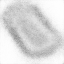

  9%|▊         | 871/10000 [03:49<46:29,  3.27it/s]

epoch: 870, loss: 0.842802882194519
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  9%|▉         | 900/10000 [03:57<39:20,  3.85it/s]

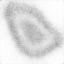

  9%|▉         | 901/10000 [03:57<39:44,  3.82it/s]

epoch: 900, loss: 0.8590467870235443


  9%|▉         | 930/10000 [04:05<39:13,  3.85it/s]

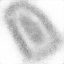

  9%|▉         | 931/10000 [04:05<39:36,  3.82it/s]

epoch: 930, loss: 0.8613892793655396


 10%|▉         | 960/10000 [04:12<39:05,  3.85it/s]

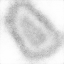

 10%|▉         | 961/10000 [04:13<39:28,  3.82it/s]

epoch: 960, loss: 0.847605288028717


 10%|▉         | 990/10000 [04:20<38:58,  3.85it/s]

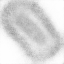

 10%|▉         | 991/10000 [04:20<39:21,  3.81it/s]

epoch: 990, loss: 0.8799731433391571


 10%|█         | 1020/10000 [04:28<38:49,  3.85it/s]

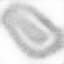

 10%|█         | 1021/10000 [04:28<39:13,  3.82it/s]

epoch: 1020, loss: 0.858503669500351


 10%|█         | 1050/10000 [04:36<38:43,  3.85it/s]

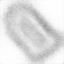

 11%|█         | 1051/10000 [04:36<45:25,  3.28it/s]

epoch: 1050, loss: 0.8216482400894165
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


 11%|█         | 1080/10000 [04:44<38:34,  3.85it/s]

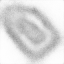

 11%|█         | 1081/10000 [04:44<38:57,  3.82it/s]

epoch: 1080, loss: 0.8645224571228027


 11%|█         | 1110/10000 [04:51<38:27,  3.85it/s]

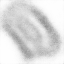

 11%|█         | 1111/10000 [04:52<38:50,  3.81it/s]

epoch: 1110, loss: 0.8757238388061523


 11%|█▏        | 1140/10000 [04:59<38:19,  3.85it/s]

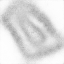

 11%|█▏        | 1141/10000 [05:00<38:42,  3.82it/s]

epoch: 1140, loss: 0.8630873560905457


 12%|█▏        | 1170/10000 [05:07<38:10,  3.85it/s]

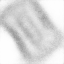

 12%|█▏        | 1171/10000 [05:07<38:33,  3.82it/s]

epoch: 1170, loss: 0.8628984689712524


 12%|█▏        | 1200/10000 [05:15<38:04,  3.85it/s]

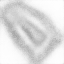

 12%|█▏        | 1201/10000 [05:15<38:26,  3.81it/s]

epoch: 1200, loss: 0.8421390652656555


 12%|█▏        | 1230/10000 [05:23<37:55,  3.85it/s]

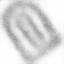

 12%|█▏        | 1231/10000 [05:23<38:18,  3.82it/s]

epoch: 1230, loss: 0.8397775590419769


 13%|█▎        | 1260/10000 [05:30<37:48,  3.85it/s]

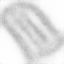

 13%|█▎        | 1261/10000 [05:31<38:10,  3.81it/s]

epoch: 1260, loss: 0.8456547260284424


 13%|█▎        | 1290/10000 [05:38<37:39,  3.85it/s]

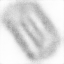

 13%|█▎        | 1291/10000 [05:39<38:01,  3.82it/s]

epoch: 1290, loss: 0.823767215013504


 13%|█▎        | 1320/10000 [05:46<37:32,  3.85it/s]

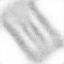

 13%|█▎        | 1321/10000 [05:46<37:55,  3.81it/s]

epoch: 1320, loss: 0.8472002744674683


 14%|█▎        | 1350/10000 [05:54<37:24,  3.85it/s]

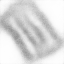

 14%|█▎        | 1351/10000 [05:54<37:46,  3.82it/s]

epoch: 1350, loss: 0.8349011540412903


 14%|█▍        | 1380/10000 [06:02<37:17,  3.85it/s]

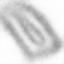

 14%|█▍        | 1381/10000 [06:02<37:38,  3.82it/s]

epoch: 1380, loss: 0.8224673271179199


 14%|█▍        | 1410/10000 [06:09<37:09,  3.85it/s]

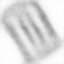

 14%|█▍        | 1411/10000 [06:10<37:30,  3.82it/s]

epoch: 1410, loss: 0.8392385542392731


 14%|█▍        | 1440/10000 [06:17<37:01,  3.85it/s]

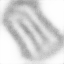

 14%|█▍        | 1441/10000 [06:17<37:23,  3.82it/s]

epoch: 1440, loss: 0.8504456579685211


 15%|█▍        | 1470/10000 [06:25<36:53,  3.85it/s]

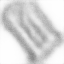

 15%|█▍        | 1471/10000 [06:25<37:15,  3.81it/s]

epoch: 1470, loss: 0.8601704835891724


 15%|█▌        | 1500/10000 [06:33<36:45,  3.85it/s]

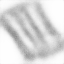

 15%|█▌        | 1501/10000 [06:33<37:07,  3.82it/s]

epoch: 1500, loss: 0.8666722476482391


 15%|█▌        | 1530/10000 [06:41<36:38,  3.85it/s]

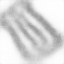

 15%|█▌        | 1531/10000 [06:41<36:59,  3.82it/s]

epoch: 1530, loss: 0.8327883183956146


 16%|█▌        | 1560/10000 [06:48<36:29,  3.85it/s]

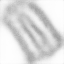

 16%|█▌        | 1561/10000 [06:49<42:32,  3.31it/s]

epoch: 1560, loss: 0.8156192600727081
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


 16%|█▌        | 1590/10000 [06:56<36:22,  3.85it/s]

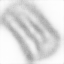

 16%|█▌        | 1591/10000 [06:57<36:43,  3.82it/s]

epoch: 1590, loss: 0.8323294818401337


 16%|█▌        | 1620/10000 [07:04<36:15,  3.85it/s]

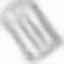

 16%|█▌        | 1621/10000 [07:04<36:35,  3.82it/s]

epoch: 1620, loss: 0.8463420271873474


 16%|█▋        | 1650/10000 [07:12<36:06,  3.85it/s]

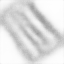

 17%|█▋        | 1651/10000 [07:12<36:27,  3.82it/s]

epoch: 1650, loss: 0.8361086249351501


 17%|█▋        | 1680/10000 [07:20<35:59,  3.85it/s]

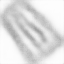

 17%|█▋        | 1681/10000 [07:20<42:17,  3.28it/s]

epoch: 1680, loss: 0.7919065654277802
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


 17%|█▋        | 1710/10000 [07:28<35:51,  3.85it/s]

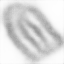

 17%|█▋        | 1711/10000 [07:28<36:13,  3.81it/s]

epoch: 1710, loss: 0.8048779368400574


 17%|█▋        | 1740/10000 [07:35<35:42,  3.85it/s]

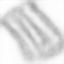

 17%|█▋        | 1741/10000 [07:36<36:04,  3.82it/s]

epoch: 1740, loss: 0.8268613517284393


 18%|█▊        | 1770/10000 [07:43<35:36,  3.85it/s]

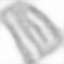

 18%|█▊        | 1771/10000 [07:43<35:56,  3.82it/s]

epoch: 1770, loss: 0.8425123989582062


 18%|█▊        | 1800/10000 [07:51<35:27,  3.85it/s]

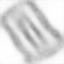

 18%|█▊        | 1801/10000 [07:51<35:48,  3.82it/s]

epoch: 1800, loss: 0.8349697589874268


 18%|█▊        | 1830/10000 [07:59<35:20,  3.85it/s]

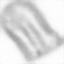

 18%|█▊        | 1831/10000 [07:59<35:41,  3.81it/s]

epoch: 1830, loss: 0.8372502028942108


 19%|█▊        | 1860/10000 [08:07<35:12,  3.85it/s]

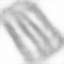

 19%|█▊        | 1861/10000 [08:07<35:32,  3.82it/s]

epoch: 1860, loss: 0.8509309589862823


 19%|█▉        | 1890/10000 [08:14<35:04,  3.85it/s]

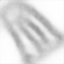

 19%|█▉        | 1891/10000 [08:15<35:25,  3.81it/s]

epoch: 1890, loss: 0.8113575875759125


 19%|█▉        | 1920/10000 [08:22<34:57,  3.85it/s]

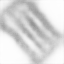

 19%|█▉        | 1921/10000 [08:22<35:17,  3.82it/s]

epoch: 1920, loss: 0.8192082941532135


 20%|█▉        | 1950/10000 [08:30<34:48,  3.85it/s]

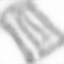

 20%|█▉        | 1951/10000 [08:30<35:08,  3.82it/s]

epoch: 1950, loss: 0.8227335810661316


 20%|█▉        | 1980/10000 [08:38<34:41,  3.85it/s]

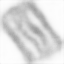

 20%|█▉        | 1981/10000 [08:38<35:01,  3.82it/s]

epoch: 1980, loss: 0.8092464208602905


 20%|██        | 2010/10000 [08:46<34:32,  3.85it/s]

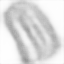

 20%|██        | 2011/10000 [08:46<34:53,  3.82it/s]

epoch: 2010, loss: 0.8236937820911407


 20%|██        | 2040/10000 [08:53<34:25,  3.85it/s]

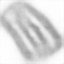

 20%|██        | 2041/10000 [08:54<34:47,  3.81it/s]

epoch: 2040, loss: 0.8391803801059723


 21%|██        | 2070/10000 [09:01<34:17,  3.85it/s]

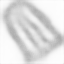

 21%|██        | 2071/10000 [09:01<34:38,  3.82it/s]

epoch: 2070, loss: 0.8237359821796417


 21%|██        | 2100/10000 [09:09<34:10,  3.85it/s]

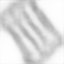

 21%|██        | 2101/10000 [09:09<34:30,  3.82it/s]

epoch: 2100, loss: 0.8220195770263672


 21%|██▏       | 2130/10000 [09:17<34:02,  3.85it/s]

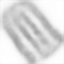

 21%|██▏       | 2131/10000 [09:17<34:23,  3.81it/s]

epoch: 2130, loss: 0.8473373055458069


 22%|██▏       | 2160/10000 [09:25<33:54,  3.85it/s]

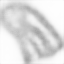

 22%|██▏       | 2161/10000 [09:25<34:14,  3.82it/s]

epoch: 2160, loss: 0.8338398039340973


 22%|██▏       | 2190/10000 [09:32<33:46,  3.85it/s]

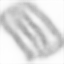

 22%|██▏       | 2191/10000 [09:33<34:06,  3.82it/s]

epoch: 2190, loss: 0.8319794237613678


 22%|██▏       | 2220/10000 [09:40<33:38,  3.85it/s]

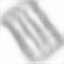

 22%|██▏       | 2221/10000 [09:40<33:58,  3.82it/s]

epoch: 2220, loss: 0.817866325378418


 22%|██▎       | 2250/10000 [09:48<33:31,  3.85it/s]

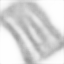

 23%|██▎       | 2251/10000 [09:48<33:51,  3.81it/s]

epoch: 2250, loss: 0.8470970094203949


 23%|██▎       | 2280/10000 [09:56<33:22,  3.85it/s]

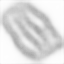

 23%|██▎       | 2281/10000 [09:56<33:42,  3.82it/s]

epoch: 2280, loss: 0.8226378858089447


 23%|██▎       | 2310/10000 [10:03<33:15,  3.85it/s]

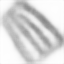

 23%|██▎       | 2311/10000 [10:04<33:35,  3.82it/s]

epoch: 2310, loss: 0.8129073083400726


 23%|██▎       | 2340/10000 [10:11<33:06,  3.86it/s]

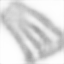

 23%|██▎       | 2341/10000 [10:12<33:26,  3.82it/s]

epoch: 2340, loss: 0.8291847109794617


 24%|██▎       | 2370/10000 [10:19<33:00,  3.85it/s]

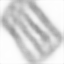

 24%|██▎       | 2371/10000 [10:19<33:19,  3.81it/s]

epoch: 2370, loss: 0.8400382101535797


 24%|██▍       | 2400/10000 [10:27<32:51,  3.85it/s]

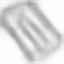

 24%|██▍       | 2401/10000 [10:27<33:10,  3.82it/s]

epoch: 2400, loss: 0.8375697433948517


 24%|██▍       | 2430/10000 [10:35<32:44,  3.85it/s]

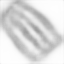

 24%|██▍       | 2431/10000 [10:35<33:04,  3.81it/s]

epoch: 2430, loss: 0.8350302577018738


 25%|██▍       | 2460/10000 [10:42<32:36,  3.85it/s]

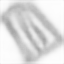

 25%|██▍       | 2461/10000 [10:43<32:55,  3.82it/s]

epoch: 2460, loss: 0.8090980648994446


 25%|██▍       | 2487/10000 [10:50<32:43,  3.83it/s]


KeyboardInterrupt: 

In [30]:
best_loss = 10000
for i in tqdm(range(epoch)):
    it = iter(data_loader)
    total_loss = 0
    count = 0
    for images in it:
        vae_optimizer.zero_grad()
        x = images.to(device)
        recon_x, mean, logvar = vae(x)
        reshaped_x = x.view(-1, 1 * 64 * 64)
        reshaped_recon_x = recon_x.view(-1, 1 * 64 * 64)
        loss = vae_loss(reshaped_recon_x, reshaped_x, mean, logvar)
        loss.backward()

        vae_optimizer.step()
        vae_schedular.step()
        total_loss += loss.item()
        del x, recon_x, mean, logvar, reshaped_x, reshaped_recon_x
        torch.cuda.empty_cache()

        count += batch_size
        if count > 100:
            break
    if i % 30 == 0:
        sampled_images = sampled_images.to(device)
        recon_x, mean, var = vae(sampled_images)
        # print(mean[0][0].item(), var[0][0].item())
        display(to_pil_image(recon_x[0]))
        print(f"epoch: {i}, loss: {total_loss}")
        sampled_images = sampled_images.cpu()
        torch.cuda.empty_cache()
        if best_loss > total_loss:
            best_loss = total_loss
            save_dir_path = "vae_model_checkpoints"
            save_path = os.path.join(
                save_dir_path,
                f"resblock_vae_{ch}_{latent_channels}_beta_{vae_loss.beta}_aug_fox_text.pt",
            )
            # save_dir_path, f"simple_vae_beta_{vae_loss.beta}_aug.pt")
            print(save_path)
            torch.save(vae.state_dict(), save_path)

  0%|          | 0/10000 [00:00<?, ?it/s]

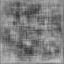

  0%|          | 1/10000 [00:00<1:21:03,  2.06it/s]

epoch: 0, loss: 1.4464767575263977
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  0%|          | 30/10000 [00:08<43:35,  3.81it/s] 

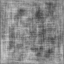

  0%|          | 31/10000 [00:08<50:48,  3.27it/s]

epoch: 30, loss: 1.363974928855896
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  1%|          | 60/10000 [00:16<43:21,  3.82it/s]

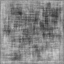

  1%|          | 61/10000 [00:16<51:00,  3.25it/s]

epoch: 60, loss: 1.305503785610199
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  1%|          | 90/10000 [00:24<43:13,  3.82it/s]

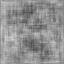

  1%|          | 91/10000 [00:24<50:39,  3.26it/s]

epoch: 90, loss: 1.2416699528694153
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  1%|          | 120/10000 [00:32<42:54,  3.84it/s]

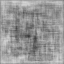

  1%|          | 121/10000 [00:32<50:21,  3.27it/s]

epoch: 120, loss: 1.1851717829704285
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  2%|▏         | 150/10000 [00:40<42:57,  3.82it/s]

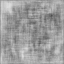

  2%|▏         | 151/10000 [00:40<50:37,  3.24it/s]

epoch: 150, loss: 1.147875428199768
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  2%|▏         | 180/10000 [00:48<42:49,  3.82it/s]

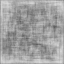

  2%|▏         | 181/10000 [00:48<50:07,  3.27it/s]

epoch: 180, loss: 1.1185347437858582
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  2%|▏         | 210/10000 [00:56<42:50,  3.81it/s]

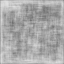

  2%|▏         | 211/10000 [00:56<50:37,  3.22it/s]

epoch: 210, loss: 1.054641842842102
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  2%|▏         | 240/10000 [01:04<42:42,  3.81it/s]

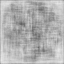

  2%|▏         | 241/10000 [01:04<49:34,  3.28it/s]

epoch: 240, loss: 1.0385960340499878
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  3%|▎         | 270/10000 [01:12<42:23,  3.83it/s]

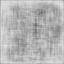

  3%|▎         | 271/10000 [01:12<50:05,  3.24it/s]

epoch: 270, loss: 1.011230230331421
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  3%|▎         | 300/10000 [01:20<42:27,  3.81it/s]

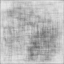

  3%|▎         | 301/10000 [01:20<49:36,  3.26it/s]

epoch: 300, loss: 0.9932816028594971
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  3%|▎         | 330/10000 [01:28<42:07,  3.83it/s]

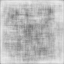

  3%|▎         | 331/10000 [01:28<49:56,  3.23it/s]

epoch: 330, loss: 0.9519495964050293
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  4%|▎         | 360/10000 [01:36<42:10,  3.81it/s]

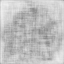

  4%|▎         | 361/10000 [01:36<42:42,  3.76it/s]

epoch: 360, loss: 0.9595477879047394


  4%|▍         | 390/10000 [01:44<41:37,  3.85it/s]

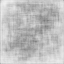

  4%|▍         | 391/10000 [01:44<42:10,  3.80it/s]

epoch: 390, loss: 0.9621925950050354


  4%|▍         | 420/10000 [01:51<41:55,  3.81it/s]

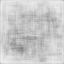

  4%|▍         | 421/10000 [01:52<49:26,  3.23it/s]

epoch: 420, loss: 0.9372332990169525
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  4%|▍         | 450/10000 [01:59<41:47,  3.81it/s]

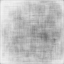

  5%|▍         | 451/10000 [02:00<48:49,  3.26it/s]

epoch: 450, loss: 0.9304661452770233
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  5%|▍         | 480/10000 [02:07<41:39,  3.81it/s]

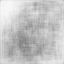

  5%|▍         | 481/10000 [02:08<49:11,  3.22it/s]

epoch: 480, loss: 0.9195003807544708
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  5%|▌         | 510/10000 [02:15<41:20,  3.83it/s]

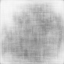

  5%|▌         | 511/10000 [02:16<41:51,  3.78it/s]

epoch: 510, loss: 0.9223653376102448


  5%|▌         | 540/10000 [02:23<41:23,  3.81it/s]

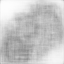

  5%|▌         | 541/10000 [02:24<41:54,  3.76it/s]

epoch: 540, loss: 0.9199255704879761


  6%|▌         | 570/10000 [02:31<41:04,  3.83it/s]

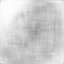

  6%|▌         | 571/10000 [02:32<47:54,  3.28it/s]

epoch: 570, loss: 0.9004553556442261
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  6%|▌         | 600/10000 [02:39<41:08,  3.81it/s]

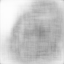

  6%|▌         | 601/10000 [02:39<41:37,  3.76it/s]

epoch: 600, loss: 0.9269455373287201


  6%|▋         | 630/10000 [02:47<40:49,  3.83it/s]

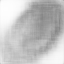

  6%|▋         | 631/10000 [02:47<48:08,  3.24it/s]

epoch: 630, loss: 0.8964417278766632
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  7%|▋         | 660/10000 [02:55<40:42,  3.82it/s]

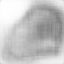

  7%|▋         | 661/10000 [02:55<47:34,  3.27it/s]

epoch: 660, loss: 0.8707497119903564
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  7%|▋         | 690/10000 [03:03<40:33,  3.83it/s]

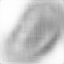

  7%|▋         | 691/10000 [03:03<41:03,  3.78it/s]

epoch: 690, loss: 0.8906804919242859


  7%|▋         | 720/10000 [03:11<40:26,  3.82it/s]

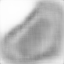

  7%|▋         | 721/10000 [03:11<40:55,  3.78it/s]

epoch: 720, loss: 0.8955193758010864


  8%|▊         | 750/10000 [03:19<40:28,  3.81it/s]

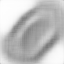

  8%|▊         | 751/10000 [03:19<47:50,  3.22it/s]

epoch: 750, loss: 0.8502523005008698
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  8%|▊         | 780/10000 [03:27<39:55,  3.85it/s]

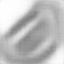

  8%|▊         | 781/10000 [03:27<40:19,  3.81it/s]

epoch: 780, loss: 0.8747836053371429


  8%|▊         | 810/10000 [03:35<40:02,  3.82it/s]

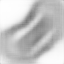

  8%|▊         | 811/10000 [03:35<40:25,  3.79it/s]

epoch: 810, loss: 0.8528148829936981


  8%|▊         | 840/10000 [03:42<39:54,  3.83it/s]

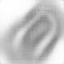

  8%|▊         | 841/10000 [03:43<40:24,  3.78it/s]

epoch: 840, loss: 0.8628685772418976


  9%|▊         | 870/10000 [03:50<39:46,  3.83it/s]

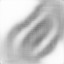

  9%|▊         | 871/10000 [03:51<46:40,  3.26it/s]

epoch: 870, loss: 0.8264807760715485
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


  9%|▉         | 900/10000 [03:58<39:39,  3.82it/s]

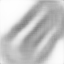

  9%|▉         | 901/10000 [03:59<40:07,  3.78it/s]

epoch: 900, loss: 0.8738342523574829


  9%|▉         | 930/10000 [04:06<39:41,  3.81it/s]

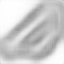

  9%|▉         | 931/10000 [04:06<40:08,  3.77it/s]

epoch: 930, loss: 0.8432416319847107


 10%|▉         | 960/10000 [04:14<39:09,  3.85it/s]

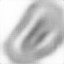

 10%|▉         | 961/10000 [04:14<39:32,  3.81it/s]

epoch: 960, loss: 0.8580899834632874


 10%|▉         | 990/10000 [04:22<39:15,  3.82it/s]

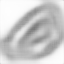

 10%|▉         | 991/10000 [04:22<39:43,  3.78it/s]

epoch: 990, loss: 0.843231588602066


 10%|█         | 1020/10000 [04:30<39:07,  3.83it/s]

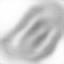

 10%|█         | 1021/10000 [04:30<39:34,  3.78it/s]

epoch: 1020, loss: 0.8506211042404175


 10%|█         | 1050/10000 [04:38<39:10,  3.81it/s]

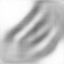

 11%|█         | 1051/10000 [04:38<39:39,  3.76it/s]

epoch: 1050, loss: 0.8484688103199005


 11%|█         | 1080/10000 [04:45<39:01,  3.81it/s]

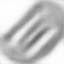

 11%|█         | 1081/10000 [04:46<45:36,  3.26it/s]

epoch: 1080, loss: 0.8077888190746307
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


 11%|█         | 1110/10000 [04:53<38:53,  3.81it/s]

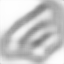

 11%|█         | 1111/10000 [04:54<39:21,  3.76it/s]

epoch: 1110, loss: 0.8546449840068817


 11%|█▏        | 1140/10000 [05:01<38:36,  3.83it/s]

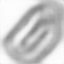

 11%|█▏        | 1141/10000 [05:02<39:04,  3.78it/s]

epoch: 1140, loss: 0.8175797760486603


 12%|█▏        | 1170/10000 [05:09<38:38,  3.81it/s]

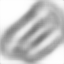

 12%|█▏        | 1171/10000 [05:09<39:06,  3.76it/s]

epoch: 1170, loss: 0.8412189781665802


 12%|█▏        | 1200/10000 [05:17<38:30,  3.81it/s]

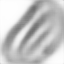

 12%|█▏        | 1201/10000 [05:17<38:58,  3.76it/s]

epoch: 1200, loss: 0.8404592573642731


 12%|█▏        | 1230/10000 [05:25<38:25,  3.80it/s]

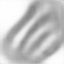

 12%|█▏        | 1231/10000 [05:25<38:52,  3.76it/s]

epoch: 1230, loss: 0.8347564339637756


 13%|█▎        | 1260/10000 [05:33<38:14,  3.81it/s]

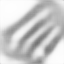

 13%|█▎        | 1261/10000 [05:33<38:42,  3.76it/s]

epoch: 1260, loss: 0.8138472437858582


 13%|█▎        | 1290/10000 [05:41<38:07,  3.81it/s]

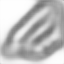

 13%|█▎        | 1291/10000 [05:41<38:34,  3.76it/s]

epoch: 1290, loss: 0.8111793398857117


 13%|█▎        | 1320/10000 [05:49<37:59,  3.81it/s]

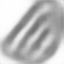

 13%|█▎        | 1321/10000 [05:49<38:27,  3.76it/s]

epoch: 1320, loss: 0.812629222869873


 14%|█▎        | 1350/10000 [05:56<37:51,  3.81it/s]

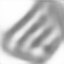

 14%|█▎        | 1351/10000 [05:57<38:18,  3.76it/s]

epoch: 1350, loss: 0.8363147675991058


 14%|█▍        | 1380/10000 [06:04<37:43,  3.81it/s]

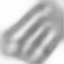

 14%|█▍        | 1381/10000 [06:05<38:11,  3.76it/s]

epoch: 1380, loss: 0.8263887465000153


 14%|█▍        | 1410/10000 [06:12<37:35,  3.81it/s]

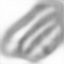

 14%|█▍        | 1411/10000 [06:13<38:02,  3.76it/s]

epoch: 1410, loss: 0.8252941966056824


 14%|█▍        | 1440/10000 [06:20<37:17,  3.83it/s]

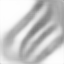

 14%|█▍        | 1441/10000 [06:20<37:44,  3.78it/s]

epoch: 1440, loss: 0.8271580636501312


 15%|█▍        | 1470/10000 [06:28<37:19,  3.81it/s]

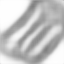

 15%|█▍        | 1471/10000 [06:28<37:46,  3.76it/s]

epoch: 1470, loss: 0.8445117771625519


 15%|█▌        | 1500/10000 [06:36<36:48,  3.85it/s]

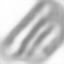

 15%|█▌        | 1501/10000 [06:36<37:15,  3.80it/s]

epoch: 1500, loss: 0.819646805524826


 15%|█▌        | 1530/10000 [06:44<36:54,  3.82it/s]

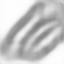

 15%|█▌        | 1531/10000 [06:44<37:20,  3.78it/s]

epoch: 1530, loss: 0.8542025089263916


 16%|█▌        | 1560/10000 [06:52<36:46,  3.82it/s]

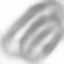

 16%|█▌        | 1561/10000 [06:52<37:12,  3.78it/s]

epoch: 1560, loss: 0.8151562809944153


 16%|█▌        | 1590/10000 [06:59<36:37,  3.83it/s]

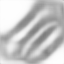

 16%|█▌        | 1591/10000 [07:00<37:04,  3.78it/s]

epoch: 1590, loss: 0.8545268177986145


 16%|█▌        | 1620/10000 [07:07<36:30,  3.83it/s]

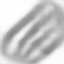

 16%|█▌        | 1621/10000 [07:07<36:57,  3.78it/s]

epoch: 1620, loss: 0.8294391334056854


 16%|█▋        | 1650/10000 [07:15<36:22,  3.83it/s]

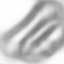

 17%|█▋        | 1651/10000 [07:15<36:48,  3.78it/s]

epoch: 1650, loss: 0.848321944475174


 17%|█▋        | 1680/10000 [07:23<36:15,  3.83it/s]

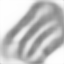

 17%|█▋        | 1681/10000 [07:23<36:41,  3.78it/s]

epoch: 1680, loss: 0.8367006778717041


 17%|█▋        | 1710/10000 [07:31<36:16,  3.81it/s]

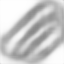

 17%|█▋        | 1711/10000 [07:31<36:41,  3.77it/s]

epoch: 1710, loss: 0.8090864717960358


 17%|█▋        | 1740/10000 [07:39<36:08,  3.81it/s]

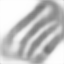

 17%|█▋        | 1741/10000 [07:39<36:35,  3.76it/s]

epoch: 1740, loss: 0.8219073414802551


 18%|█▊        | 1770/10000 [07:47<35:51,  3.83it/s]

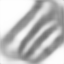

 18%|█▊        | 1771/10000 [07:47<36:17,  3.78it/s]

epoch: 1770, loss: 0.8392598927021027


 18%|█▊        | 1800/10000 [07:54<35:52,  3.81it/s]

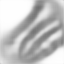

 18%|█▊        | 1801/10000 [07:55<36:19,  3.76it/s]

epoch: 1800, loss: 0.8261831998825073


 18%|█▊        | 1830/10000 [08:02<35:36,  3.82it/s]

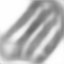

 18%|█▊        | 1831/10000 [08:03<36:01,  3.78it/s]

epoch: 1830, loss: 0.8395659923553467


 19%|█▊        | 1860/10000 [08:10<35:28,  3.82it/s]

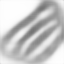

 19%|█▊        | 1861/10000 [08:10<35:54,  3.78it/s]

epoch: 1860, loss: 0.8558866679668427


 19%|█▉        | 1890/10000 [08:18<35:20,  3.82it/s]

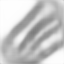

 19%|█▉        | 1891/10000 [08:18<41:40,  3.24it/s]

epoch: 1890, loss: 0.7968109548091888
vae_model_checkpoints/resblock_vae_64_32_beta_0.001_aug_fox_text.pt


 19%|█▉        | 1920/10000 [08:26<35:22,  3.81it/s]

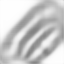

 19%|█▉        | 1921/10000 [08:26<35:48,  3.76it/s]

epoch: 1920, loss: 0.8323141932487488


 20%|█▉        | 1950/10000 [08:34<35:04,  3.83it/s]

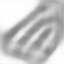

 20%|█▉        | 1951/10000 [08:34<35:29,  3.78it/s]

epoch: 1950, loss: 0.8005141317844391


 20%|█▉        | 1980/10000 [08:42<35:06,  3.81it/s]

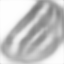

 20%|█▉        | 1981/10000 [08:42<35:31,  3.76it/s]

epoch: 1980, loss: 0.8265587091445923


 20%|██        | 2010/10000 [08:50<34:36,  3.85it/s]

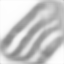

 20%|██        | 2011/10000 [08:50<35:01,  3.80it/s]

epoch: 2010, loss: 0.8065416514873505


 20%|██        | 2040/10000 [08:57<34:49,  3.81it/s]

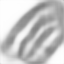

 20%|██        | 2041/10000 [08:58<35:15,  3.76it/s]

epoch: 2040, loss: 0.8218946754932404


 21%|██        | 2070/10000 [09:05<34:33,  3.83it/s]

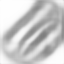

 21%|██        | 2071/10000 [09:06<34:55,  3.78it/s]

epoch: 2070, loss: 0.8286725282669067


 21%|██        | 2100/10000 [09:13<34:25,  3.82it/s]

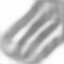

 21%|██        | 2101/10000 [09:13<34:50,  3.78it/s]

epoch: 2100, loss: 0.8237772285938263


 21%|██▏       | 2130/10000 [09:21<34:17,  3.83it/s]

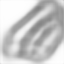

 21%|██▏       | 2131/10000 [09:21<34:41,  3.78it/s]

epoch: 2130, loss: 0.8506167232990265


 22%|██▏       | 2160/10000 [09:29<34:18,  3.81it/s]

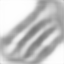

 22%|██▏       | 2161/10000 [09:29<34:43,  3.76it/s]

epoch: 2160, loss: 0.8325963020324707


 22%|██▏       | 2190/10000 [09:37<34:01,  3.83it/s]

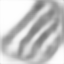

 22%|██▏       | 2191/10000 [09:37<34:25,  3.78it/s]

epoch: 2190, loss: 0.8131386339664459


 22%|██▏       | 2220/10000 [09:45<34:03,  3.81it/s]

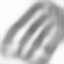

 22%|██▏       | 2221/10000 [09:45<34:28,  3.76it/s]

epoch: 2220, loss: 0.8154787719249725


 22%|██▎       | 2250/10000 [09:52<33:46,  3.83it/s]

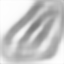

 23%|██▎       | 2251/10000 [09:53<34:10,  3.78it/s]

epoch: 2250, loss: 0.8253543376922607


 23%|██▎       | 2280/10000 [10:00<33:38,  3.83it/s]

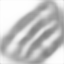

 23%|██▎       | 2281/10000 [10:01<34:03,  3.78it/s]

epoch: 2280, loss: 0.816811591386795


 23%|██▎       | 2290/10000 [10:03<33:52,  3.79it/s]


KeyboardInterrupt: 

In [ ]:
best_loss = 10000
for i in tqdm(range(epoch)):
    it = iter(data_loader)
    total_loss = 0
    count = 0
    for images in it:
        vae_optimizer.zero_grad()
        x = images.to(device)
        recon_x, mean, logvar = vae(x)
        reshaped_x = x.view(-1, 1 * 64 * 64)
        reshaped_recon_x = recon_x.view(-1, 1 * 64 * 64)
        loss = vae_loss(reshaped_recon_x, reshaped_x, mean, logvar)
        loss.backward()

        vae_optimizer.step()
        vae_schedular.step()
        total_loss += loss.item()
        del x, recon_x, mean, logvar, reshaped_x, reshaped_recon_x
        torch.cuda.empty_cache()

        count += batch_size
        if count > 100:
            break
    if i % 30 == 0:
        sampled_images = sampled_images.to(device)
        recon_x, mean, var = vae(sampled_images)
        # print(mean[0][0].item(), var[0][0].item())
        display(to_pil_image(recon_x[0]))
        print(f"epoch: {i}, loss: {total_loss}")
        sampled_images = sampled_images.cpu()
        torch.cuda.empty_cache()
        if best_loss > total_loss:
            best_loss = total_loss
            save_dir_path = "vae_model_checkpoints"
            save_path = os.path.join(
                save_dir_path,
                f"resblock_vae_{ch}_{latent_channels}_beta_{vae_loss.beta}_aug_fox_text.pt",
            )
            # save_dir_path, f"simple_vae_beta_{vae_loss.beta}_aug.pt")
            print(save_path)
            torch.save(vae.state_dict(), save_path)

In [ ]:
save_dir_path = "vae_model_checkpoints"
save_path = os.path.join(
    save_dir_path, f"resblock_vae_beta_{vae_loss.beta}_fox_text_aug.pt"
)
# save_dir_path, f"simple_vae_beta_{vae_loss.beta}_aug.pt")
print(save_path)
torch.save(vae.state_dict(), save_path)

vae_model_checkpoints/resblock_vae_beta_0.01_fox_text_aug.pt


In [ ]:
def builder(image1, image2, slider):
    with torch.no_grad():
        if image1 is None:
            return None
        if image2 is None:
            return None
        x1 = vae_preprocess(image1).unsqueeze(0).to(device)
        x2 = vae_preprocess(image2).unsqueeze(0).to(device)
        recon_x1, mean1, var1 = vae(x1)
        recon_x2, mean2, var2 = vae(x2)
        interporated_mean = mean1 * (1 - slider) + mean2 * slider
        recon_x = vae.decoder(interporated_mean)
        return to_pil_image(recon_x[0])


with gr.Blocks() as demo:
    with gr.Row():
        image1 = gr.Image(label="", type="pil")
        image2 = gr.Image(label="", type="pil")
        slider = gr.Slider(0, 1, value=0, step=0.1, label="slider")
    with gr.Row():
        image3 = gr.Image(label="", type="pil")

    image1.change(fn=builder, inputs=[
                  image1, image2, slider], outputs=[image3])
    image2.change(fn=builder, inputs=[
                  image1, image2, slider], outputs=[image3])
    slider.change(fn=builder, inputs=[
                  image1, image2, slider], outputs=[image3])

demo.launch(debug=True, share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://4e6f232434b07f32e9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4e6f232434b07f32e9.gradio.live
